<h1> Financial Econometrics II – Master 203 - Projects - Trend Following Strategy <h1> <h3> Ben Ahmed Komara </h3>
<h3> Fernandes Neres Benjamin <h3> Mohamed Mohamed Abdellahi </h3>

<h2> Data Preparation and Preliminary Analysis <h2>

**Import libraries and data**

In [3]:
import Kalman_trend as k
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from scipy.stats import skew, kurtosis, jarque_bera
import statsmodels.api as sm
from sklearn.linear_model import Lasso
from sklearn import preprocessing
from sklearn.linear_model import LassoCV

**Data Loading**

In [4]:
data_SP500=pd.read_excel('GROUP DATASET.xlsx', 'Feuil2',usecols='A:B',index_col=0)
data_SP500= data_SP500.iloc[1:]
data_SP500

,S&P500 net total return index
"Data source: Bloomberg, Orion Financial Partners",
1999-01-04,1668.52
1999-01-05,1691.23
1999-01-06,1728.94
1999-01-07,1725.47
1999-01-08,1732.75
...,...
2025-11-24,12835.97
2025-11-25,12952.86
2025-11-26,13042.48


Data Processing for Kalman filter

In [5]:
dates=pd.to_datetime(data_SP500.index)
daily_prices_SP500=np.array(data_SP500) # We transform the pandas dataframe in to an array for Kalman Filter

**Local Linear Trend**

In [6]:
# The Kalman filter needs : Yt, Xt and Ut as entries.
# We know that for each step, as we use the trend following model, we have Xt=(1 0)

c=np.ones((len(daily_prices_SP500),1))
z=np.zeros((len(daily_prices_SP500),1))
xt=np.concatenate((c,z),axis=1)

# We don't have any control variables so that we put u=0
yt = np.log(daily_prices_SP500.astype(float).flatten())
output=k.Kalman(yt,xt,0)

Optimization terminated successfully.
         Current function value: -2.759564
         Iterations: 12
         Function evaluations: 120
         Gradient evaluations: 20


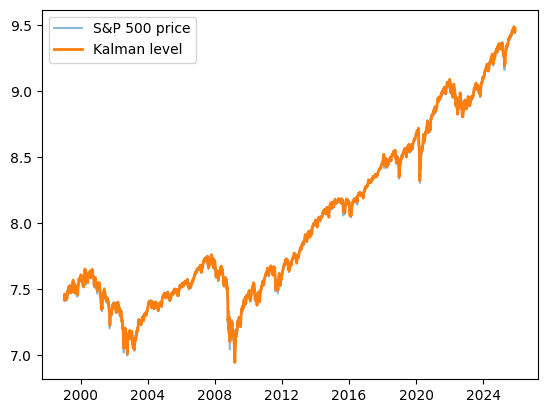

In [7]:
T_t = output[0][:, 0]         
plt.plot(dates,yt, label="S&P 500 price", alpha=0.5)
plt.plot(dates,T_t, label="Kalman level", linewidth=2)
plt.legend()

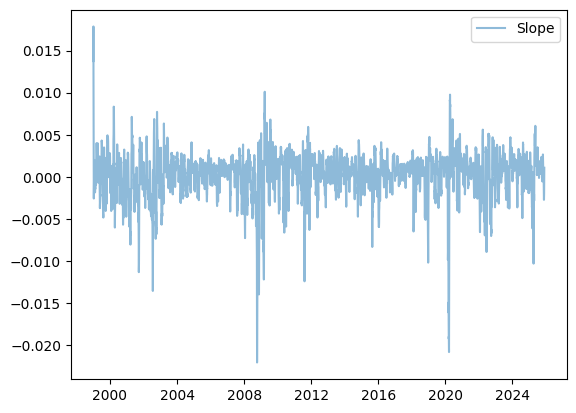

In [8]:
S_t = output[0][:, 1]
# Note: The first value can be an outlier due to the initialization of the filter, so we look only after 1:
# => C'est curieux la première valeur est 0.4 ...
plt.plot(dates[1:],S_t[1:], label="Slope", alpha=0.5)
plt.legend()

# Q1) From what level of the spread Δₜ could we consider that the difference between the S&P500 index and its trend is “abnormal” ?

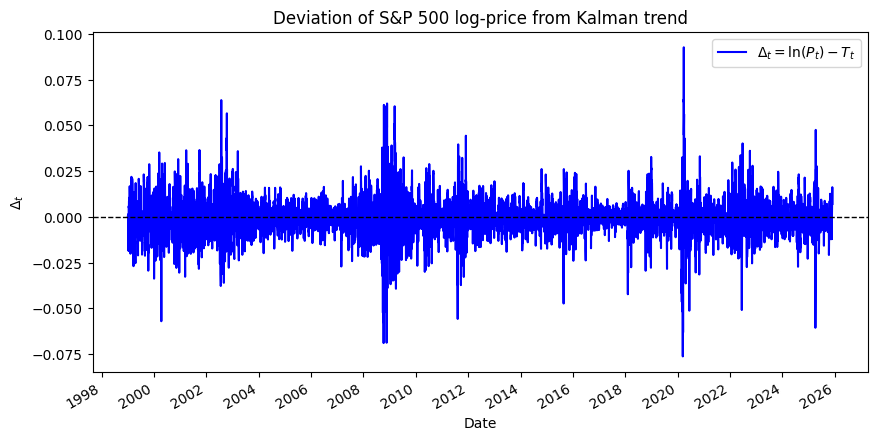

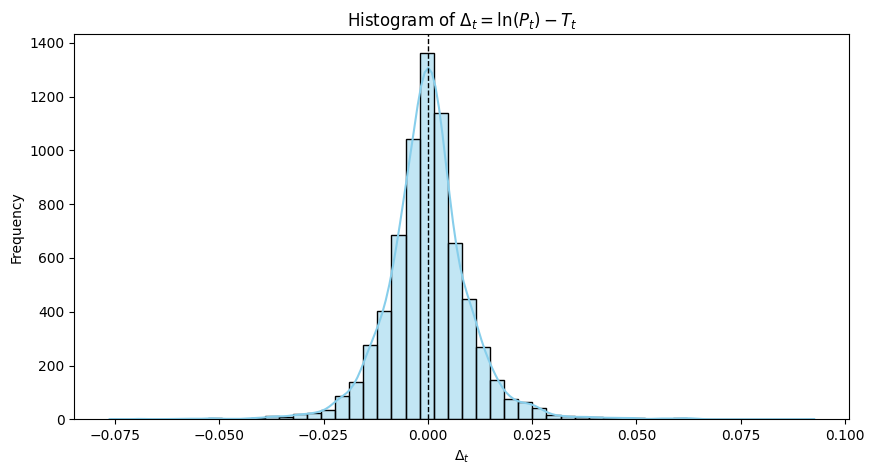

In [9]:
# Δ_t = ln(P_t) - T_t
Delta = yt - T_t

# Tracé
plt.figure(figsize=(10,5))
plt.plot(dates, Delta, label=r'$\Delta_t = \ln(P_t) - T_t$', color='blue')

# ligne zéro pour référence
plt.axhline(0, color='black', linewidth=1, linestyle='--')

# formatage des dates
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator(base=2))
plt.gcf().autofmt_xdate()

plt.title("Deviation of S&P 500 log-price from Kalman trend")
plt.xlabel("Date")
plt.ylabel(r"$\Delta_t$")
plt.legend()
plt.show()

# Histogramme avec KDE
plt.figure(figsize=(10,5))
sns.histplot(Delta, bins=50, kde=True, color='skyblue')

# ligne zéro pour référence
plt.axvline(0, color='black', linewidth=1, linestyle='--')

plt.title(r"Histogram of $\Delta_t = \ln(P_t) - T_t$")
plt.xlabel(r"$\Delta_t$")
plt.ylabel("Frequency")
plt.show()

In [10]:
# Statistiques classiques
mean_delta = np.mean(Delta)
var_delta  = np.var(Delta, ddof=1)      # variance échantillon
skew_delta = skew(Delta)
kurt_delta = kurtosis(Delta, fisher=False)  # Fisher=False => 3 pour normale

# Jarque-Bera statistic (valeur brute)
JB_stat, _ = jarque_bera(Delta)

# Valeurs attendues pour une normale
mean_normal = 0
var_normal  = 1
skew_normal = 0
kurt_normal = 3
JB_normal  = 0  # Jarque-Bera = 0 pour une normale parfaite

# Résumé pandas pour affichage propre
summary = pd.DataFrame({
    'Statistic': ['Mean', 'Variance', 'Skewness', 'Kurtosis', 'JB_stat'],
    'Delta_t': [mean_delta, var_delta, skew_delta, kurt_delta, JB_stat],
    'Normal expected': [mean_normal, var_normal, skew_normal, kurt_normal, JB_normal]
})

print(summary)

  Statistic       Delta_t  Normal expected
0      Mean     -0.000003                0
1  Variance      0.000108                1
2  Skewness      0.211111                0
3  Kurtosis      9.212747                3
4   JB_stat  11342.126220                0


In [11]:
#  Calcul des quantiles
q_low, q_high = np.quantile(Delta, [0.05, 0.95])
print(f"5%-quantile (lower bound) : {q_low:.6f}")
print(f"95%-quantile (upper bound): {q_high:.6f}\n")

#  Extraction des cas “anormaux”
abnormal = Delta[(Delta < q_low) | (Delta > q_high)]

# Affichage des valeurs anormales
print(f"Number of 'abnormal' points: {len(abnormal)}")
print("Some examples of abnormal Δ_t values:")
print(pd.Series(abnormal))


5%-quantile (lower bound) : -0.015367
95%-quantile (upper bound): 0.015827

Number of 'abnormal' points: 702
Some examples of abnormal Δ_t values:
0     -0.018571
1     -0.018349
2      0.016708
3     -0.020156
4      0.021859
         ...   
697   -0.018149
698   -0.015777
699   -0.020855
700    0.015939
701    0.016181
Length: 702, dtype: float64




The variable : 

$$
\Delta_t = \ln(P_t) - T_t
$$

measures the deviation of the observed log-price $P_t$ from its latent Kalman trend $T_t$.  

We have shown that the distribution of $\Delta_t$ is **clearly non-Gaussian**, with heavy tails and skewness, and the Jarque-Bera test strongly rejects normality. Therefore, standard deviation-based thresholds are unreliable.  

Abnormal deviations are defined using **empirical quantiles**, for example:  

$$
\Delta_t < Q_{0.05} \quad \text{or} \quad \Delta_t > Q_{0.95}
$$

where $Q_{0.05}$ and $Q_{0.95}$ are the 5%- and 95%-quantiles of the $\Delta_t$ distribution, capturing extreme movements or atypical market episodes.


# Q2)  Are some of the macro factors provided good explanatory factors of the level spread level?

# Variance Inflation Factor (VIF) Analysis

Before running regressions of the spread $\Delta_t$ on macroeconomic factors, we check for **multicollinearity** among the explanatory variables using the Variance Inflation Factor (VIF).  

- Each factor is regressed on all other factors, and the VIF is calculated as:  

$$
\text{VIF}_i = \frac{1}{1 - R_i^2}
$$

where $R_i^2$ is the coefficient of determination of the regression of factor $i$ on the remaining factors.  

- **Interpretation:**  
  - VIF ≈ 1 → little or no collinearity  
  - VIF > 5 (or 10) → high collinearity; factor may need to be removed or combined  

By computing VIF, we identify and potentially exclude highly collinear macro factors, ensuring that our regression coefficients for $\Delta_t$ are stable and interpretable.  



In [12]:
data_macro = pd.read_excel(
    'GROUP DATASET.xlsx',
    sheet_name='Feuil2',    # nom de la feuille
    usecols='A:M',          # colonnes SP500 + macro factors
    index_col=0             # première colonne comme index (SP500 ou date)
)

# Supprimer la première ligne de description si nécessaire
data_macro = data_macro.iloc[1:]
data_macro.drop(columns=['S&P500 net total return index'], inplace=True)

# Afficher un aperçu
data_macro


,TED Spread (USA),Equity implied volatility (USA),High yield spread (USA),Global liquidity risk index,Global market risk index,Global credit risk index,Global FX risk index,Macro cycle (USA),Macro cycle (DVP),Macro cycle USA (3 months variation),Macro cycle - dvp (3 month variation)
"Data source: Bloomberg, Orion Financial Partners",,,,,,,,,,,
1999-01-04,0.58831,26.17,563,-0.425038,0.092936,1.242224,0.788118,0.722628,0.252417,0.016776,-0.013004
1999-01-05,0.57431,24.46,557,0.584583,0.275358,1.152422,0.609058,0.722628,0.251733,0.016776,-0.012592
1999-01-06,0.60631,23.34,556,0.570934,-0.088812,1.193793,0.439895,0.743839,0.259383,0.04202,-0.00641
1999-01-07,0.6245,24.37,553,0.484931,0.406243,1.172206,0.367209,0.747058,0.261614,0.017492,-0.010196
1999-01-08,0.56481,23.28,541,0.404513,0.277222,1.127302,0.360412,0.752244,0.257027,0.022678,-0.014355
...,...,...,...,...,...,...,...,...,...,...,...
2025-11-24,0.2167,20.52,315,0.305404,0.42344,-0.384636,-1.101898,-0.091522,-0.012186,-0.044593,-0.028214
2025-11-25,0.246,18.56,310,0.687865,0.088921,-0.423929,-1.189613,-0.123568,-0.030158,-0.085032,-0.049454
2025-11-26,0.1394,17.19,300,-0.091968,-0.20084,-0.561976,-1.256451,-0.135555,-0.036109,-0.102204,-0.055511


In [13]:
# Assurons-nous que toutes les colonnes sont float
data_macro = data_macro.astype(float)

# Initialiser le VIF array
VIF = np.zeros(data_macro.shape[1])

# Boucle sur chaque facteur
for i in range(data_macro.shape[1]):
    # Régress le facteur i sur tous les autres
    model = sm.OLS(data_macro.iloc[:, i], sm.add_constant(data_macro.drop(data_macro.columns[i], axis=1)))
    results = model.fit()
    VIF[i] = 1 / (1 - results.rsquared)

# Tableau clair avec noms de facteurs et VIF
table_VIF = pd.DataFrame({
    "Factor": data_macro.columns,
    "VIF": np.round(VIF, 2)
})

table_VIF

,Factor,VIF
0,TED Spread (USA),1.97
1,Equity implied volatility (USA),4.79
2,High yield spread (USA),4.35
3,Global liquidity risk index,1.85
4,Global market risk index,2.42
5,Global credit risk index,2.61
6,Global FX risk index,2.00
7,Macro cycle (USA),17.36
8,Macro cycle (DVP),17.41
9,Macro cycle USA (3 months variation),15.70


**Results interpretation:**  

- **Low to moderate collinearity (VIF ≈ 1–5):**  
  TED Spread, Equity implied volatility, High yield spread, Global liquidity risk index, Global market risk index, Global credit risk index, Global FX risk index.  
  These factors are suitable for inclusion in the regression.

- **High collinearity (VIF > 10):**  
  Macro cycle (USA), Macro cycle (DVP), Macro cycle USA (3 months variation), Macro cycle - DVP (3 months variation).  
  These factors are strongly correlated with each other. It is recommended to **select one or combine them** to avoid unstable regression coefficients.


# LASSO Regression Approach

To explain the spread $\Delta_t$ using macroeconomic factors, we opt for a **LASSO regression** rather than Ridge regression.  

- Unlike Ridge, LASSO can **shrink some coefficients exactly to zero**, providing automatic **variable selection**.  
- This is particularly useful given the **high collinearity** among some macro factors (e.g., the macro cycle variables with high VIF).  
- LASSO helps produce a **parsimonious and interpretable model**, retaining only the most relevant explanatory variables.  

The next step is to visualize the **regularization path**, plotting each coefficient as a function of the penalization parameter $\lambda$. Unlike in the course, we fully standardize both the macro factors and the spread level before applying LASSO. This ensures that the penalization affects all coefficients comparably, regardless of the original scale of the variables, and allows for a meaningful comparison of factor importance.


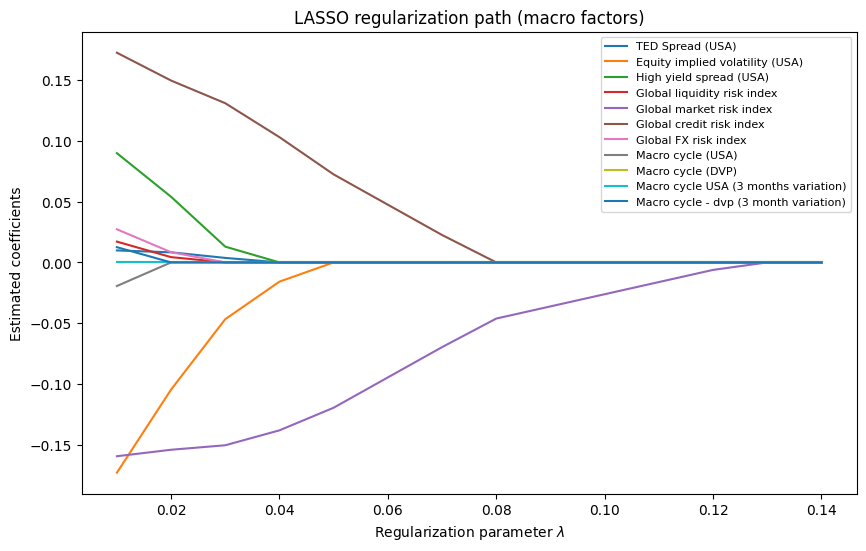

In [14]:
# ===============================
# Data
# ===============================

# Explanatory variables (macros)
X = np.array(data_macro)
FACTOR_NAMES = data_macro.columns

# Dependent variable: spread level Δ_t
Y = np.array(Delta).reshape(-1, 1)

# Standardization (as in the course)
X = preprocessing.scale(X, with_mean=True)
Y = preprocessing.scale(Y, with_mean=True)

# ===============================
# LASSO path
# ===============================

lambda_range = np.arange(0.01, 0.15, 0.01)
lasso_path = np.zeros((lambda_range.shape[0], X.shape[1]))

for j, lam in enumerate(lambda_range):
    model = Lasso(alpha=lam, fit_intercept=True, max_iter=10000)
    model.fit(X, Y.ravel())
    lasso_path[j, :] = model.coef_

# ===============================
# Plot coefficient paths
# ===============================
plt.figure(figsize=(10,6))

for i, name in enumerate(data_macro.columns):
    plt.plot(lambda_range, lasso_path[:, i], label=name)

plt.xlabel(r"Regularization parameter $\lambda$")
plt.ylabel("Estimated coefficients")
plt.title("LASSO regularization path (macro factors)")
plt.legend(loc='best', fontsize=8)
plt.show()



The regularization parameter $\lambda$ is selected using **cross-validation**, in order to minimize the out-of-sample mean squared prediction error.  
Given the size of the dataset, we rely on **10-fold cross-validation**, which provides a well-established compromise between bias and variance in the estimation of prediction errors. This approach ensures a robust and stable selection of $\lambda$, while limiting the sensitivity of the results to sampling variability.


In [15]:
# ----------------------------
# Data preparation
# ----------------------------
X = np.array(data_macro)        # macro factors
Y = np.array(Delta)             # spread level Δ_t

# Standardization (crucial for LASSO)
X = preprocessing.scale(X, with_mean=True)
Y = preprocessing.scale(Y, with_mean=True)

# ----------------------------
# Lambda grid
# ----------------------------
lambda_range = np.arange(1e-4, 1, 1e-3)

# ----------------------------
# LASSO with 10-fold cross-validation only
# ----------------------------
model_lasso = LassoCV(
    alphas=lambda_range,
    fit_intercept=True,
    cv=10,
    max_iter=10000
)

model_lasso.fit(X, Y)

# ----------------------------
# Output DataFrame
# ----------------------------
lasso_summary = pd.DataFrame(
    model_lasso.coef_,
    index=data_macro.columns,
    columns=["LASSO coefficient (10-fold CV)"]
)

# Add sum of betas
lasso_summary.loc["sum_beta"] = lasso_summary.sum()
# Add sum of absolute betas
lasso_summary.loc["sum_abs_beta"] = lasso_summary.abs().sum()

# Display optimal lambda and the table
print("Optimal lambda (10-fold CV):", model_lasso.alpha_)
lasso_summary


Optimal lambda (10-fold CV): 0.0131


,LASSO coefficient (10-fold CV)
TED Spread (USA),0.008744
Equity implied volatility (USA),-0.150132
High yield spread (USA),0.080067
Global liquidity risk index,0.012821
Global market risk index,-0.157964
Global credit risk index,0.163073
Global FX risk index,0.021620
Macro cycle (USA),-0.009763
Macro cycle (DVP),-0.000000
Macro cycle USA (3 months variation),0.000000


### Note

Looking at the LASSO coefficients around the optimal λ (10-fold CV), we notice that the **macro cycle factors** receive very small coefficients:

- `Macro cycle (USA)` ≈ -0.0098  
- `Macro cycle (DVP)` ≈ 0  
- `Macro cycle USA (3 months variation)` ≈ 0  
- `Macro cycle - dvp (3 month variation)` ≈ 0.0043  

These results are consistent with the **high VIF values** we observed previously for these factors (VIF > 15), indicating strong **multicollinearity**.  
LASSO automatically shrinks the coefficients of highly collinear variables, often to zero, to prevent instability in the regression.  
Hence, these macro cycle variables contribute little to the predictive model of Δ_t once penalization is applied, while other factors with lower VIF maintain larger coefficients and are considered more informative.


## Q3) We implement a trend-following strategy on the S&P500 index using one or more of the following signals:

- Slope of the latent trend: $S_t$  
- Expected slope based on macro factors: $\hat{S}_t = f(\text{macro factors})$  
- Spread threshold crossings: $\Delta_t$ beyond the limits identified in Question 1  

**Note:** The trading decision at time $t$ uses only information available at time $t-1$, ensuring the strategy is implementable.


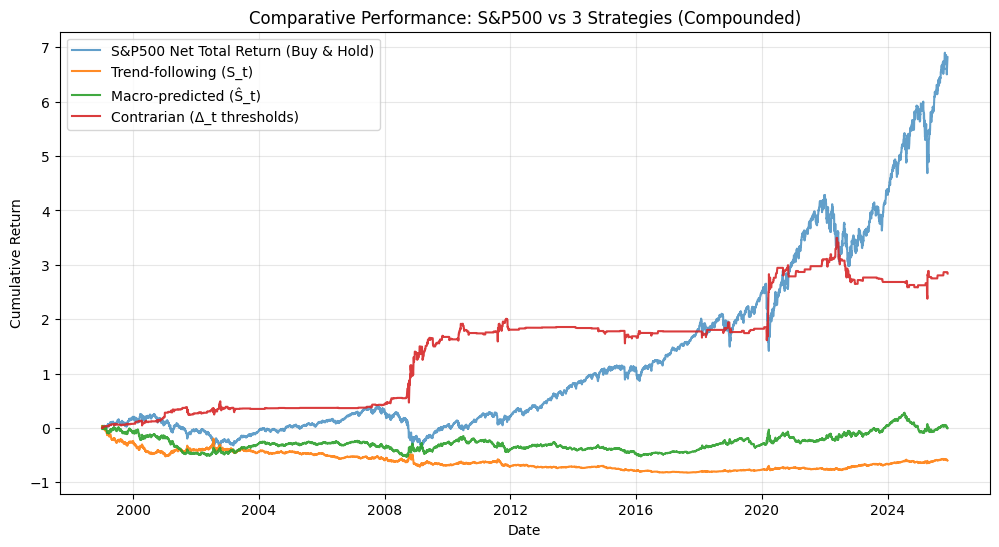

In [30]:
# ============================================================
# Q3 — 3 stratégies + S&P500 (clean & readable version)
# IMPORTANT: use compounded cumulative returns (NOT np.cumsum)
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler


# ----------------------------
# 0) Small helper: compounded cumulative return
# ----------------------------
def cumret(r):
    r = np.nan_to_num(np.array(r, dtype=float), nan=0.0)
    return np.cumprod(1.0 + r) - 1.0


# ----------------------------
# 1) Compute daily returns (from index levels)
# ----------------------------
daily_prices_array = np.array(data_SP500, dtype=float).flatten()   # size N
daily_returns = daily_prices_array[1:] / daily_prices_array[:-1] - 1.0   # size N-1
dates_aligned = np.array(dates)[1:]                                 # align with returns

# S&P 500 Buy&Hold cumulative return (proper for an index level)
cum_sp500 = daily_prices_array[1:] / daily_prices_array[0] - 1.0    # size N-1


# ----------------------------
# 2) Strategy 1: Trend-following (sign of S_t)
# ----------------------------
S_t = np.array(S_t, dtype=float)                                    # size N

signal_slope = np.sign(np.nan_to_num(S_t, nan=0.0))                 # size N
position_slope = np.roll(signal_slope, 1)                           # lag by 1 (t based on t-1)
position_slope[0] = 0
position_slope_aligned = position_slope[1:]                         # size N-1

ret_slope = position_slope_aligned * daily_returns                  # strategy daily returns
cum_slope = cumret(ret_slope)


# ----------------------------
# 3) Strategy 2: Macro-predicted slope Ŝ_t (LASSO)
# Clean alignment:
#   X_t = macro at day t (0..N-2)
#   Y_{t+1} = S_t at day t+1 (1..N-1)
# so prediction is for next day slope.
# ----------------------------
data_macro = np.array(data_macro, dtype=float)                      # expected size (N, K)

X_macro = data_macro[:-1, :]                                        # size (N-1, K)
Y_slope = S_t[1:]                                                   # size (N-1,)

scaler = StandardScaler(with_mean=True, with_std=True)
X_macro_scaled = scaler.fit_transform(X_macro)

lasso = LassoCV(cv=10, max_iter=10000, random_state=0).fit(X_macro_scaled, Y_slope)

S_hat_pred = lasso.predict(X_macro_scaled)                          # size (N-1,)
S_hat = np.zeros_like(S_t)                                          # size N
S_hat[1:] = S_hat_pred                                              # align prediction at t (t>=1)

signal_slope_hat = np.sign(np.nan_to_num(S_hat, nan=0.0))           # size N
position_slope_hat = np.roll(signal_slope_hat, 1)
position_slope_hat[0] = 0
position_slope_hat_aligned = position_slope_hat[1:]                 # size N-1

ret_slope_hat = position_slope_hat_aligned * daily_returns
cum_slope_hat = cumret(ret_slope_hat)


# ----------------------------
# 4) Strategy 3: Contrarian on Δ_t thresholds
# ----------------------------
Delta = np.array(Delta, dtype=float)                                # size N

q_low, q_high = np.nanquantile(Delta, [0.05, 0.95])

signal_delta = np.zeros_like(Delta)
signal_delta[Delta < q_low]  =  1
signal_delta[Delta > q_high] = -1

position_delta = np.roll(signal_delta, 1)
position_delta[0] = 0
position_delta_aligned = position_delta[1:]                         # size N-1

ret_delta = position_delta_aligned * daily_returns
cum_delta = cumret(ret_delta)


# ----------------------------
# 5) Plot cumulative PERFORMANCE (compounded)
# ----------------------------
plt.figure(figsize=(12,6))
plt.plot(dates_aligned, cum_sp500, label="S&P500 Net Total Return (Buy & Hold)", alpha=0.7)
plt.plot(dates_aligned, cum_slope, label="Trend-following (S_t)", alpha=0.9)
plt.plot(dates_aligned, cum_slope_hat, label="Macro-predicted (Ŝ_t)", alpha=0.9)
plt.plot(dates_aligned, cum_delta, label="Contrarian (Δ_t thresholds)", alpha=0.9)
plt.title("Comparative Performance: S&P500 vs 3 Strategies (Compounded)")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()



## Regime-Dependent Trading Strategy

The empirical results obtained from the individual strategies highlight an important feature of financial markets: no single signal consistently dominates across all market conditions. The trend-following strategy based on the estimated slope captures persistent market movements but performs poorly during periods of low trend intensity or frequent reversals. The macro-predicted slope incorporates forward-looking economic information, but its predictive power remains unstable over time. Finally, the contrarian strategy based on deviations from trend performs particularly well during crisis periods, but remains mostly inactive during normal market conditions.

Rather than interpreting these signals as competing strategies, they should be viewed as complementary indicators capturing different market regimes. Large deviations between prices and their estimated trend reflect abnormal market conditions in which mean-reversion forces dominate. Conversely, when prices evolve close to their long-term trend, market dynamics are better described by trend continuation mechanisms, potentially reinforced by macroeconomic conditions.

This motivates the construction of a regime-dependent trading strategy. When the spread between the log-price and its trend exceeds the thresholds identified in Question 1, the strategy adopts a contrarian position. Outside these extreme regimes, trading decisions rely on trend-following signals, combining both the realized slope of the trend and its macro-predicted counterpart. Importantly, this approach does not rely on any parameter optimization or ex post adjustment. All thresholds and signals are defined ex ante and use only information available at time t−1.

Formally, let $\text{Position}_t \in \{-1, 0, +1\}$ denote the position taken on the S\&P 500 index at time $t$. The trading rule is defined as follows:

$$
\text{Position}_t =
\begin{cases}
+1 & \text{if } \Delta_{t-1} < q_{\text{low}}, \\
-1 & \text{if } \Delta_{t-1} > q_{\text{high}}, \\
\text{sign}\!\left(S_{t-1} + \hat S_{t-1}\right) & \text{otherwise}.
\end{cases}
$$


This strategy allows the trading rule to adapt to changing market environments while maintaining economic coherence and methodological simplicity. Its objective is not to systematically outperform the S\&P 500, but to construct a robust and interpretable trading framework that exploits different sources of information depending on market con


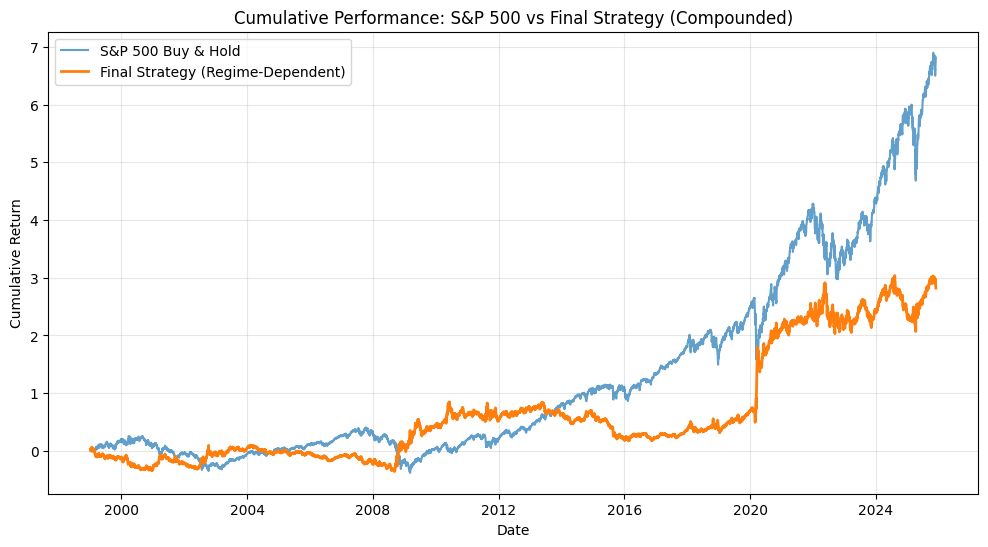

Activity rate (non-zero position) = 100.00%
Share of contrarian regime (Delta outside [q_low,q_high]) ≈ 10.00%


In [31]:
# ----------------------------
# Final Strategy: Regime-Dependent Combination
# ----------------------------

# Initialize signal
signal_final = np.zeros_like(Delta, dtype=float)

# Regime 1: Extreme deviations -> contrarian
signal_final[Delta < q_low]  =  1    # long
signal_final[Delta > q_high] = -1    # short

# Regime 2: Normal regime -> trend-following (realized + macro-predicted slope)
normal_regime = (Delta >= q_low) & (Delta <= q_high)

combo_signal = S_t + S_hat
signal_final[normal_regime] = np.sign(np.nan_to_num(combo_signal[normal_regime], nan=0.0))

# Lag positions to avoid look-ahead bias
position_final = np.roll(signal_final, 1)
position_final[0] = 0

# Align with daily returns (N-1)
position_final_aligned = position_final[1:]

# Compute strategy daily returns + compounded cumulative performance
ret_final = position_final_aligned * daily_returns
cum_final = np.cumprod(1.0 + np.nan_to_num(ret_final, nan=0.0)) - 1.0


# ----------------------------
# Cumulative returns comparison
# ----------------------------

# If you already computed it earlier:
# cum_sp500 = daily_prices_array[1:] / daily_prices_array[0] - 1
# Otherwise you can use compounded returns:
# cum_sp500 = np.cumprod(1 + daily_returns) - 1

plt.figure(figsize=(12,6))

plt.plot(
    dates_aligned,
    cum_sp500,
    label="S&P 500 Buy & Hold",
    alpha=0.7
)

plt.plot(
    dates_aligned,
    cum_final,
    label="Final Strategy (Regime-Dependent)",
    linewidth=2
)

plt.title("Cumulative Performance: S&P 500 vs Final Strategy (Compounded)")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


# ----------------------------
# Quick diagnostics (optional but useful)
# ----------------------------
activity_rate = np.mean(position_final_aligned != 0)
share_contrarian = np.mean((Delta[1:] < q_low) | (Delta[1:] > q_high))   # regime frequency (aligned-ish)

print(f"Activity rate (non-zero position) = {activity_rate:.2%}")
print(f"Share of contrarian regime (Delta outside [q_low,q_high]) ≈ {share_contrarian:.2%}")


## Q4) Compute the average annualized performance of your strategy and its Sharpe ratio. According to these two metrics, can you conclude that the performance of your strategy (positive or negative) is due to luck or not?

In [34]:
# ----------------------------
# Helpers: annualized metrics
# ----------------------------
def annualized_return(r, periods_per_year=252):
    r = np.asarray(r, dtype=float)
    r = r[np.isfinite(r)]
    n = r.size
    if n == 0:
        return np.nan
    total_growth = np.prod(1.0 + r)
    return total_growth**(periods_per_year / n) - 1.0

def annualized_vol(r, periods_per_year=252):
    r = np.asarray(r, dtype=float)
    r = r[np.isfinite(r)]
    if r.size < 2:
        return np.nan
    return np.std(r, ddof=1) * np.sqrt(periods_per_year)

def sharpe_ratio(r, rf=0.0, periods_per_year=252):
    r = np.asarray(r, dtype=float)
    r = r[np.isfinite(r)]
    if r.size < 2:
        return np.nan
    excess = r - rf / periods_per_year
    vol = np.std(excess, ddof=1)
    if vol == 0 or not np.isfinite(vol):
        return np.nan
    return np.mean(excess) / vol * np.sqrt(periods_per_year)

def equity_curve(r):
    """Return equity curve starting at 1."""
    r = np.asarray(r, dtype=float)
    r = np.nan_to_num(r, nan=0.0, posinf=0.0, neginf=0.0)
    return np.cumprod(1.0 + r)

def max_drawdown_from_returns(r):
    """
    Max drawdown computed from returns via equity curve.
    Returns a negative number (e.g. -0.35 for -35%).
    """
    eq = equity_curve(r)
    running_max = np.maximum.accumulate(eq)
    dd = eq / running_max - 1.0
    return np.min(dd)

# ----------------------------
# Series: S&P500 vs Final strategy
# ----------------------------
r_sp500 = daily_returns          # buy & hold daily returns
r_final = ret_final              # <-- IMPORTANT: strategy daily returns (not cum, not pnl cum)

# Compounded cumulative performance (for plotting / DD)
cum_sp500 = equity_curve(r_sp500) - 1.0
cum_final = equity_curve(r_final) - 1.0

# ----------------------------
# Compute metrics
# ----------------------------
metrics = pd.DataFrame({
    "Strategy": ["S&P 500 Buy & Hold", "Final Strategy (Regime-Dependent)"],
    "Ann. Return": [annualized_return(r_sp500), annualized_return(r_final)],
    "Ann. Vol": [annualized_vol(r_sp500), annualized_vol(r_final)],
    "Sharpe (rf=0)": [sharpe_ratio(r_sp500), sharpe_ratio(r_final)],
    "Max Drawdown": [max_drawdown_from_returns(r_sp500), max_drawdown_from_returns(r_final)]
})

metrics_style = metrics.style.format({
    "Ann. Return": "{:.2%}",
    "Ann. Vol": "{:.2%}",
    "Sharpe (rf=0)": "{:.2f}",
    "Max Drawdown": "{:.2%}"
})

metrics_style


,Strategy,Ann. Return,Ann. Vol,Sharpe (rf=0),Max Drawdown
0,S&P 500 Buy & Hold,7.66%,19.00%,0.48,-55.71%
1,Final Strategy (Regime-Dependent),4.93%,19.00%,0.35,-41.16%


### Performance Analysis and Interpretation

Table X reports the annualized performance metrics of the S&P 500 Net Total Return Index and the final regime-dependent trading strategy. Several important observations can be drawn from these results.

First, the S&P 500 Buy & Hold benchmark delivers an annualized return of approximately 7.7% over the sample period, with an annualized volatility close to 19%. This level of performance is fully consistent with historical evidence for a total return equity index over a long horizon. The associated Sharpe ratio of 0.48 reflects the well-known equity risk premium, albeit with substantial drawdowns, as illustrated by a maximum drawdown exceeding 50%.

The regime-dependent strategy exhibits a lower annualized return, around 4.9%, while displaying a volatility level comparable to that of the benchmark. As a consequence, the Sharpe ratio of the strategy (0.35) remains below that of the S&P 500. This indicates that, over the full sample, the strategy does not outperform the market on a risk-adjusted basis.

However, an important improvement is observed in terms of downside risk. The maximum drawdown of the regime-dependent strategy is significantly reduced relative to the benchmark (approximately −41% versus −56%). This reduction in drawdown highlights the stabilizing role of the contrarian component during periods of extreme deviations from trend, particularly during major market stress episodes.

Overall, these results confirm that combining multiple signals does not automatically lead to market outperformance. Instead, the main contribution of the regime-dependent framework lies in its ability to adapt trading behavior to different market environments, thereby improving risk control and drawdown characteristics. The strategy should therefore be interpreted as a robust and economically coherent allocation rule rather than as an attempt to systematically beat the S&P 500 Net Total Return Index.


### Statistical Significance of Strategy Performance

We assess whether the observed performance of the trading strategy reflects genuine skill or can be attributed to randomness. The null hypothesis tested is

$$
H_0:\quad \mathbb{E}[r_t] = 0.
$$

The daily return of the trading strategy is defined as

$$
r_t = \frac{P_t - P_{t-1}}{P_{t-1}} \times \text{Position}_{t-1}.
$$

Under this hypothesis, the strategy does not generate abnormal performance and any observed return or Sharpe ratio is driven by chance.

Classical parametric tests rely on strong assumptions such as independent and normally distributed returns, which are often violated in financial time series. To avoid these assumptions, we adopt a non-parametric bootstrap approach.

The procedure is implemented as follows. First, the return series is centered in order to satisfy the null hypothesis:

$$
r_t^{(0)} = r_t - \bar r.
$$

Second, a block bootstrap is applied to the centered returns in order to preserve the time-series dependence structure. For each bootstrap replication, a pseudo-sample of returns is generated and the corresponding performance statistics are recomputed.

The observed performance statistic is denoted by

$$
\theta.
$$

Its bootstrap counterpart obtained from resampled returns is denoted by

$$
\theta^{*}.
$$

This yields an empirical distribution of the performance measures under the null hypothesis. Statistical significance is assessed using a two-sided p-value defined as

$$
p = \mathbb{P}\left( \left| \theta^{*} \right| \ge \left| \theta \right| \right).
$$

If the p-value is below conventional significance levels, the null hypothesis is rejected, indicating that the observed performance is unlikely to be due to chance. Otherwise, the null hypothesis cannot be rejected and the strategy’s performance is considered statistically indistinguishable from randomness.


In [36]:
# ============================================================
# Helpers: performance metrics (already used previously)
# ============================================================
# These functions compute the performance statistics of interest
# from a series of daily returns.

def annualized_return(r, periods_per_year=252):
    """
    Geometric annualized return computed from daily returns.
    """
    r = np.asarray(r, dtype=float)
    r = r[np.isfinite(r)]
    n = r.size
    if n == 0:
        return np.nan
    total_growth = np.prod(1.0 + r)
    return total_growth**(periods_per_year / n) - 1.0

def sharpe_ratio(r, rf=0.0, periods_per_year=252):
    """
    Annualized Sharpe ratio (risk-free rate set to zero).
    """
    r = np.asarray(r, dtype=float)
    r = r[np.isfinite(r)]
    if r.size < 2:
        return np.nan
    excess = r - rf / periods_per_year
    vol = np.std(excess, ddof=1)
    if vol == 0 or not np.isfinite(vol):
        return np.nan
    return np.mean(excess) / vol * np.sqrt(periods_per_year)

# ============================================================
# Block bootstrap under the null hypothesis H0: E[r_t] = 0
# ============================================================
# This function generates bootstrap samples of returns that
# satisfy the null hypothesis of zero expected return.
# A block bootstrap is used to preserve time-series dependence.

def block_bootstrap(r_centered, block_len=21, B=5000, seed=42):
    rng = np.random.default_rng(seed)
    r = np.asarray(r_centered, dtype=float)
    r = r[np.isfinite(r)]
    n = r.size

    # Circular extension of the series to avoid edge effects
    r_ext = np.concatenate([r, r[:block_len]])

    # Number of blocks needed to rebuild a series of length n
    k = int(np.ceil(n / block_len))

    # Storage for bootstrap samples
    boot_samples = np.empty((B, n))

    for b in range(B):
        # Randomly draw starting points for each block
        starts = rng.integers(0, n, size=k)

        # Concatenate blocks and truncate to length n
        sample = np.concatenate([r_ext[s:s+block_len] for s in starts])[:n]
        boot_samples[b, :] = sample

    return boot_samples

# ============================================================
# Q4 — Bootstrap test: "Luck or not?"
# ============================================================

# ----------------------------
# 1) Observed performance of the strategy
# ----------------------------
# These are the performance metrics computed from the actual
# strategy returns (the ones we observe in the data).

obs_ann_return = annualized_return(r_final)
obs_sharpe = sharpe_ratio(r_final, rf=0.0)

# ----------------------------
# 2) Impose the null hypothesis H0: E[r_t] = 0
# ----------------------------
# Under H0, the strategy has zero expected return.
# We enforce this by centering the return series.

r_centered = r_final - np.mean(r_final)

# ----------------------------
# 3) Bootstrap parameters
# ----------------------------
B = 5000          # number of bootstrap replications
block_len = 21    # block length ≈ one trading month

# ----------------------------
# 4) Generate bootstrap samples under H0
# ----------------------------
# Each bootstrap sample represents a "world" in which the strategy
# has zero expected return, but similar dependence structure.

boot_returns = block_bootstrap(
    r_centered,
    block_len=block_len,
    B=B
)

# ----------------------------
# 5) Bootstrap distributions of performance metrics
# ----------------------------
# For each bootstrap sample, we recompute the same statistics
# as for the observed strategy.

boot_ann_return = np.array([
    annualized_return(boot_returns[b]) for b in range(B)
])

boot_sharpe = np.array([
    sharpe_ratio(boot_returns[b], rf=0.0) for b in range(B)
])

# ----------------------------
# 6) Two-sided bootstrap p-values
# ----------------------------
# The p-value measures how extreme the observed statistic is
# relative to its distribution under H0.

p_ann_return = np.mean(np.abs(boot_ann_return) >= np.abs(obs_ann_return))
p_sharpe = np.mean(np.abs(boot_sharpe) >= np.abs(obs_sharpe))

# ----------------------------
# 7) Summary table
# ----------------------------
# The table compares observed performance to the bootstrap test.

bootstrap_results = pd.DataFrame({
    "Metric": ["Annualized Return", "Sharpe Ratio (rf=0)"],
    "Observed": [obs_ann_return, obs_sharpe],
    "p-value (H0: mean = 0)": [p_ann_return, p_sharpe]
})

bootstrap_results.style.format({
    "Observed": "{:.4f}",
    "p-value (H0: mean = 0)": "{:.4f}"
})


,Metric,Observed,p-value (H0: mean = 0)
0,Annualized Return,0.0493,0.2114
1,Sharpe Ratio (rf=0),0.3479,0.0604


While the strategy delivers a positive annualized return, its bootstrap p-value indicates that this performance is not statistically significant. The Sharpe ratio provides slightly stronger evidence of risk-adjusted performance, but remains insufficient to reject the null hypothesis at the 5% level. Overall, the strategy’s performance cannot be distinguished from luck at conventional confidence levels.